In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
import tqdm
import scipy.optimize
import healpy as hp
# sys.path.append('/home/zhuoqizhang/miniconda3/envs/shearDM/lib/python3.10/site-packages/')
import pymaster as nmt
import os
nside = 1024
npix = hp.nside2npix(nside)

In [2]:
def rotate_ellipticities(e1, e2, rot_angle):
        """
        Random rotate ellipticities e1 and e2 over
        angles given in `rot_angle`, which is in
        units of radians
        """

        #Rotate galaxy shapes randomly
        cos = np.cos(rot_angle)
        sin = np.sin(rot_angle)

        e1_rand = + e1 * cos + e2 * sin
        e2_rand = - e1 * sin + e2 * cos

        return e1_rand, e2_rand

In [3]:
fname = 'DESY3_MetacalCat_Mask_All.npy'
N=50

data_array = np.load(fname)
e1 = data_array['e1']
e2 = -data_array['e2']
ra = data_array['ra']
dec = data_array['dec']
weight = data_array['w']


pix = hp.nside2npix(nside)
map_counts = np.zeros(npix)
map_e1 = np.zeros(npix)
map_e2 = np.zeros(npix)
pix = hp.ang2pix(nside, ra, dec, lonlat=True)
ind, counts = np.unique(pix, return_counts=True)
map_weight = np.bincount(pix, weight, minlength=npix)
# Note that we set response to 1. This shouldn't change the relative amplitude of C_ell
map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_weight
map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_weight
map_e1[np.isnan(map_e1)] = 0
map_e2[np.isnan(map_e2)] = 0
mask = map_weight


edge = (np.linspace(np.sqrt(8), np.sqrt(2048), 33)**2).astype(np.int_)
b = nmt.NmtBin.from_edges(edge[:-1],edge[1:])
ell_eff = b.get_effective_ells()
f2 = nmt.NmtField(mask, [map_e1, map_e2])

/tmp/ipykernel_1272793/1036733914.py:20: RuntimeWarning: invalid value encountered in true_divide
  map_e1 += np.bincount(pix,e1*weight,minlength=npix)/map_weight
/tmp/ipykernel_1272793/1036733914.py:21: RuntimeWarning: invalid value encountered in true_divide
  map_e2 += np.bincount(pix,e2*weight,minlength=npix)/map_weight


In [4]:
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f2, f2, b)
cl_coupled = nmt.compute_coupled_cell(f2, f2)
cl_decoupled = w.decouple_cell(cl_coupled)

100%|██████████| 50/50 [33:57<00:00, 40.76s/it]


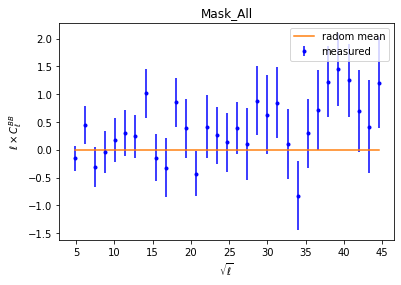

In [5]:
#np.save(f'/project2/chihway/jackie/decade/Bmode-DES/Cl_{fname[17:]}', cl_decoupled)


footprint = mask!=0
BB_rand = []

for j in tqdm.trange(N): 

    # generate random_samples
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    rot_angle = np.random.default_rng(j).random(e1.size)*2*np.pi
    e1_rot, e2_rot = rotate_ellipticities(e1, e2, rot_angle)

    rand_e1 = np.zeros(npix)
    rand_e2 = np.zeros(npix)
    rand_e1[footprint] = np.bincount(pix,e1_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
    rand_e2[footprint] = np.bincount(pix,e2_rot*weight,minlength=npix)[footprint]/map_weight[footprint]
    frand = nmt.NmtField(mask, [rand_e1, rand_e2])
    BB_rand.append(w.decouple_cell(nmt.compute_coupled_cell(frand, frand)))

BB_rand = np.array(BB_rand)   
#np.save(f'/project2/chihway/jackie/decade/Bmode-DES/rand_{fname[17:]}', BB_rand)


mean = np.mean(BB_rand[:,3,1:],axis=0)
std = np.std(BB_rand[:,3,1:],axis=0)
plt.errorbar(np.sqrt(ell_eff[1:]), 1e8*ell_eff[1:]*(cl_decoupled[3][1:]-mean), yerr=1e8*ell_eff[1:]*std,label='measured',fmt='.b')
plt.plot(np.sqrt(ell_eff[1:]), 0*mean, color='tab:orange',label='radom mean')
plt.legend()
plt.xlabel(r'$\sqrt{\ell}$')
plt.ylabel(r'$\ell\times C_\ell^{BB}$')
plt.title(fname[17:-4])
plt.show()

In [6]:
np.sum((cl_decoupled[3][1:]-mean)**2/std**2)

40.12651431184128